# Exploratory Data Analysis (EDA) e visualização exploratória

Este notebook tem como objetivo apresentar a análise exploratória realizada no conjunto de dados de treinamento brevemente descrito na [proposta do capstone](https://github.com/vivianyamassaki/Whats-cooking/blob/master/README.md), assim como a visualização exploratória para o problema denominado [What's cooking?](https://www.kaggle.com/c/whats-cooking) .

#### Versão do Python utilizada

In [1]:
from platform import python_version

print('Versão do Python: ' + python_version())

Versão do Python: 3.7.1


#### Importação das bibliotecas utilizadas

In [2]:
import pandas as pd
import json
import re
from nltk.corpus import stopwords
from collections import Counter
from operator import itemgetter

# para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize as TK

# durante a primeira execução, foi necessário fazer os dois downloads abaixo para utilizar neste notebook
#nltk.download('punkt')
#nltk.download('wordnet')

In [64]:
# altera o tamanho das imagens
plt.rcParams["figure.figsize"] = (9, 6)

#### Importação do conjunto de treinamento

O conjunto de treinamento está em formato JSON, portando é necessário usar a função __read_json__ do pandas para realizar a leitura do arquivo.

In [5]:
train = pd.read_json('../dados/train/train.json', encoding='utf-8')

## Descrição geral do conjunto de dados

In [6]:
print(f"O conjunto de treinamento possui {train.shape[0]} exemplos, cada qual representando uma receita, e \
{train.shape[1]} colunas, que são as seguintes:") 

O conjunto de treinamento possui 39774 exemplos, cada qual representando uma receita, e 3 colunas, que são as seguintes:


* **cuisine**: tipo de culinária da qual a receita pertence. Essa é a variável resposta (a classe que o modelo a ser criado deve prever)
* **id**: número identificador único da receita
* **ingredients**: lista de ingredientes que compõem a receita

In [7]:
# visualização das cinco primeira receitas presentes no conjunto de dados
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [8]:
# print de algumas informações sobre o conjunto de treinamento
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


Como é possível observar acima, não há nenhuma coluna no conjunto de treinamento com valores faltantes, visto que não há nenhum exemplo com dados nulos.

Além disso, também é possível identificar os tipos de informações presentes no conjunto de dados:

|coluna|tipo|
|------|----|
|`cuisine`| string|
|`id`| int|
|`ingredients`| lista de strings|

In [9]:
print(f"Com relação à variável resposta, temos {len(train.cuisine.unique())} \
tipos de cozinha diferentes presentes no conjunto de treinamento. Isso significa que o problema a ser resolvido \
é multiclasse, visto que há mais de duas classes presentes no conjunto de dados.")

Com relação à variável resposta, temos 20 tipos de cozinha diferentes presentes no conjunto de treinamento. Isso significa que o problema a ser resolvido é multiclasse, visto que há mais de duas classes presentes no conjunto de dados.


Esses 20 tipos diferentes de cozinha estão descritos na tabela abaixo. A tabela contém uma coluna contando o número da cozinha (apenas para facilitar a contagem das 20 cozinhas), a bandeira do país de origem do tipo de cozinha, o nome da cozinha presente no conjunto de dados e esse nome de cozinha traduzido para o português:

|#|bandeira|nome no dataset| nome traduzido|
|--|--|---|--|
|1|<img src="../figuras/flags/brazil.png" width="40"/>|brazilian|brasileira|
|2|<img src="../figuras/flags/united-kingdom.png" width="40"/>|british|britânica|
|3|<img src="../figuras/flags/united-states.png" width="40"/>|cajun_creole| cajun/crioula<sup>1</sup>|
|4|<img src="../figuras/flags/china.png" width="40"/>|chinese| chinesa|
|5|<img src="../figuras/flags/philippines.png" width="40"/>|filipino| filipina|
|6|<img src="../figuras/flags/france.png" width="40"/>|french| francesa|
|7|<img src="../figuras/flags/greece.png" width="40"/>|greek| grega|
|8|<img src="../figuras/flags/india.png" width="40"/>|indian| indiana|
|9|<img src="../figuras/flags/ireland.png" width="40"/>|irish| irlandesa|
|10|<img src="../figuras/flags/italy.png" width="40"/>|italian| italiana|
|11|<img src="../figuras/flags/jamaica.png" width="40"/>|jamaican| jamaicana|
|12|<img src="../figuras/flags/japan.png" width="40"/>|japanese| japonesa|
|13|<img src="../figuras/flags/south-korea.png" width="40"/>|korean| coreana|
|14|<img src="../figuras/flags/mexico.png" width="40"/>|mexican| mexicana|
|15|<img src="../figuras/flags/morocco.png" width="40"/>|moroccan| marroquina|
|16|<img src="../figuras/flags/russia.png" width="40"/>|russian| russa|
|17|<img src="../figuras/flags/united-states.png" width="40"/>|southern_us|sulista (do sul dos Estados Unidos)|
|18|<img src="../figuras/flags/spain.png" width="40"/>|spanish| espanhola|
|19|<img src="../figuras/flags/thailand.png" width="40"/>|thai| tailandesa|
|20|<img src="../figuras/flags/vietnam.png" width="40"/>|vietnamese| vietnamita|

<sup>1</sup> As culinárias cajun/crioula são originárias do estado da Luisiana, localizado na região sul dos Estados Unidos. Esse [link](https://www.louisianatravel.com/articles/cajun-vs-creole-food-what-difference) explica a diferença entre esses dois tipos de cozinha.

<sup>* Os ícones das bandeiras foram criados pelo [Freepik](https://www.flaticon.com/packs/international-flags-2), licenciado pela [Creative Commons BY 3.0](http://creativecommons.org/licenses/by/3.0/).</sup>

Por fim, além do número de classes, também podemos verificar a quantidade de ingredientes únicos presentes no conjunto de dados:

In [10]:
# função para calcular ingredientes únicos presentes na lista
def unique(data):
    return list(dict.fromkeys(data))

In [11]:
print(f"O conjunto de dados contém {len(unique([j for i in train['ingredients'] for j in i]))} ingredientes únicos:")

O conjunto de dados contém 6714 ingredientes únicos:


In [12]:
# lista os ingredientes únicos, de forma ordenada
ingredientes = unique([j for i in train['ingredients'] for j in i])
ingredientes.sort()
for i in ingredientes:
    print(i)

(    oz.) tomato sauce
(   oz.) tomato paste
(10 oz.) frozen chopped spinach
(10 oz.) frozen chopped spinach, thawed and squeezed dry
(14 oz.) sweetened condensed milk
(14.5 oz.) diced tomatoes
(15 oz.) refried beans
1% low-fat buttermilk
1% low-fat chocolate milk
1% low-fat cottage cheese
1% low-fat milk
2 1/2 to 3 lb. chicken, cut into serving pieces
2% low fat cheddar chees
2% low-fat cottage cheese
2% lowfat greek yogurt
2% milk shredded mozzarella cheese
2% reduced-fat milk
25% less sodium chicken broth
33% less sodium cooked deli ham
33% less sodium cooked ham
33% less sodium ham
33% less sodium smoked fully cooked ham
40% less sodium taco seasoning
40% less sodium taco seasoning mix
7 Up
8 ounc ziti pasta, cook and drain
95% lean ground beef
A Taste of Thai Rice Noodles
Accent Seasoning
Adobo All Purpose Seasoning
Alaskan king crab legs
Alexia Waffle Fries
Alfredo sauce
Amarena cherries
Amaretti Cookies
American cheese
Anaheim chile
Angostura bitters
Argo Corn Starch
Asian chili

cayenne pepper
cayenne pepper sauce
ceci bean
celery
celery flakes
celery heart
celery leaves
celery powder
celery ribs
celery root
celery salt
celery seed
celery stick
celery tops
celtic salt
center cut bacon
center cut loin pork chop
center cut pork chops
center cut pork loin chops
center cut pork roast
center-cut salmon fillet
century eggs
cereal
cereal flakes
ceylon cinnamon
chaat masala
chai tea concentrate
challa
chambord
champagne
champagne grapes
champagne vinegar
chana dal
channa dal
chanterelle
chapati flour
chapatti flour
char
char fillets
char siu
char siu sauce
chard
chardonnay
chat masala
chateaubriand
chayotes
cheddar cheese
cheddar cheese soup
chees fresco queso
chees fresh mozzarella
chees mozzarella stick
cheese
cheese cubes
cheese curds
cheese dip
cheese ravioli
cheese sauce
cheese slices
cheese soup
cheese spread
cheese sticks
cheese tortellini
chenpi
cherries
cherry coke
cherry gelatin
cherry juice
cherry peppers
cherry pie filling
cherry preserves
cherry syrup
che

greens
gremolata
grenadine
grenadine syrup
grill seasoning
grilled chicken
grilled chicken breasts
grilled chicken strips
grissini
grit quick
grits
ground Italian sausage
ground allspice
ground almonds
ground asafetida
ground beef
ground bison
ground black pepper
ground blanched almonds
ground caraway
ground cardamom
ground cashew
ground cayenne pepper
ground chicken
ground chicken breast
ground chile
ground chipotle chile pepper
ground chuck
ground cinnamon
ground cloves
ground coffee
ground coriander
ground cumin
ground dried shrimp
ground espresso
ground fennel
ground flaxseed
ground ginger
ground hazelnuts
ground lamb
ground meat
ground mustard
ground nutmeg
ground nuts
ground oregano
ground paprika
ground peanut
ground pecans
ground pepper
ground peppercorn
ground poppy seed
ground pork
ground pork sausage
ground red pepper
ground roasted sichuan peppers
ground rosemary
ground round
ground sage
ground sausage
ground sichuan pepper
ground sirloin
ground sumac
ground thyme
ground tu

low-fat shredded cheddar cheese
low-fat smoked sausage
low-fat soft goat cheese
low-fat sour cream
low-fat soy milk
low-fat spaghetti sauce
low-fat sweetened condensed milk
low-fat tartar sauce
low-fat turkey kielbasa
low-fat vanilla ice cream
low-fat vanilla wafers
low-fat vanilla yogurt
low-fat vegetable primavera spaghetti sauce
low-fat vegetarian chili with beans
low-fat white sauce
low-fat yogurt
low-sodium fat-free chicken broth
low-sodium low-fat chicken broth
lower sodium beef broth
lower sodium chicken broth
lower sodium soy sauce
lowfat pepper jack cheese
lowfat plain greekstyl yogurt
lox
luke warm water
lump crab meat
lumpia skins
lumpia wrappers
luncheon meat
lychees
maca powder
macadamia nuts
macaroni
macaroni and cheese dinner
macarons
mace
mackerel
mackerel fillets
madagascar bourbon vanilla extract
madeira wine
madeleine
mahi mahi
mahi mahi fillets
mahimahi
mahimahi fillet
mahlab
maida flour
maifun
maitake mushrooms
maldon sea salt
malt
malt powder
malt syrup
malt vineg

puy lentils
pâte brisée
pâté
quahog clams
quail
quail eggs
quatre épices
queso anejo
queso asadero
queso blanco
queso crema
queso fresca
queso fresco
queso manchego
queso panela
quick cooking brown rice
quick oats
quick yeast
quick-cooking barley
quick-cooking hominy grits
quick-cooking oats
quick-cooking tapioca
quickcooking grits
quince paste
quinces
quinoa
rabbit
rack of lamb
raclette
radicchio
radicchio leaves
radish slices
radish sprouts
radishes
ragu
ragu cheesi classic alfredo sauc
ragu cheesi doubl cheddar sauc
ragu old world style pasta sauc
ragu old world style sweet tomato basil pasta sauc
ragu old world style tradit pasta sauc
ragu pizza quick sauc
rainbow trout
raisin bread
raisins
raita
rajma
raki
ramen
ramen noodle soup
ramen noodles
ramen noodles seasoning
ramen soup mix
ramps
ranch dip
ranch dip mix
ranch dressing
ranch salad dressing mix
ranch-style seasoning
rape
rapeseed oil
rapid rise yeast
ras el hanout
raspberries
raspberry fruit spread
raspberry jam
raspberry ju

sunflower kernels
sunflower oil
sunflower seed butter
sunflower seeds
superfine sugar
superfine white sugar
sushi grade tuna
sushi nori
sushi rice
sushi vinegar
swanson beef broth
swanson chicken broth
swanson chicken stock
swede
sweet & sour stir fry sauce
sweet and sour mix
sweet and sour sauce
sweet baking chocolate
sweet basil
sweet bean paste
sweet bean sauce
sweet biscuit crumbs
sweet cherries
sweet chili sauce
sweet chocolate
sweet chorizo
sweet corn
sweet corn kernels
sweet cream butter
sweet gherkin
sweet italian pork sausage
sweet italian sausag links, cut into
sweet italian sausage
sweet mini bells
sweet mustard
sweet onion
sweet paprika
sweet peas
sweet pepper
sweet pickle
sweet pickle juice
sweet pickle relish
sweet potato starch
sweet potato vermicelli
sweet potatoes
sweet potatoes & yams
sweet potatoes or yams
sweet red bean paste
sweet relish
sweet rice
sweet rice flour
sweet rice wine
sweet sherry
sweet soy
sweet soy sauce
sweet tea
sweet turkey sausage
sweet vermouth


Observando a lista dos ingredientes únicos acima, é possível notar que é necessário realizar um tratamento dos dados, visto que há casos de:

* ingredientes com letras maiúsculas (por exemplo, `Alfredo sauce`)
* números indicando a proporção de ingredientes a serem utilizados (por exemplo, `(14.5 oz.) diced tomatoes`)
* unidades de medida (por exemplo, `(    oz.) tomato sauce`)
* caracteres especiais (por exemplo, `I Can't Believe It's Not Butter!® All Purpose Sticks`)
* palavras no plural e singular (por exemplo, `egg` e `eggs`)

Esses tratamentos serão realizados na próxima seção antes do ínicio das análises exploratórias.

Para comparar as mudanças no conjunto de dados devido aos tratamentos, será adicionada uma coluna com a quantidade inicial de ingredientes em cada exemplo:

In [13]:
# cria uma nova coluna contendo a quantidade de ingredientes presentes em cada receita
train['ingredients_qtt'] = train['ingredients'].apply(lambda x: len(x))

In [14]:
train.head()

,cuisine,id,ingredients,ingredients_qtt
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


## Tratamento dos dados

#### Conversão para letras minúsculas

In [15]:
train['processed_ingredients'] = train['ingredients'].apply(lambda x: list(map(lambda x:x.lower(),x)))

In [16]:
print(f"Após deixar todos os ingredientes para letras minúsculas, restaram \
{len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes únicos.")

Após deixar todos os ingredientes para letras minúsculas, restaram 6703 ingredientes únicos.


#### Remoção de unidades medidas

Observando a lista de ingredientes, foram encontradas as seguintes palavras indicando unidades de medida:

* [oz.](https://en.wikipedia.org/wiki/Ounce)
* [ounc](https://en.wikipedia.org/wiki/Ounce) (Ounce escrita de maneira incorreta)
* [lb.](https://en.wikipedia.org/wiki/Pound_(mass))
* [pound](https://en.wikipedia.org/wiki/Pound_(mass))
* [inch](https://en.wikipedia.org/wiki/Inch)

Todos esses casos serão removidos do conjunto de dados:

In [17]:
train['processed_ingredients'] = train['processed_ingredients'].apply(lambda x: 
                                        list(map(lambda x:x.replace('oz.', '')
                                                 .replace('ounc', '')
                                                 .replace('lb.', '')
                                                 .replace('pound', '')
                                                 .replace(' inch', '')
                                                 ,x)))

In [18]:
print(f"Após a remoção das unidades de medida, restaram \
{len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes únicos.")

Após a remoção das unidades de medida, restaram 6702 ingredientes únicos.


#### Remoção números e caracteres especiais

In [19]:
' '.join(sorted([char for char in 
                 set(' '.join(" ".join(str(review) for review in unique([j for i in train['processed_ingredients'] for j in i])))) 
                 if re.findall('[^a-z]', char)]))

"  ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 ® â ç è é í î ú ’ € ™"

A lista acima indica todos os caracteres númericos e especiais presentes no conjunto de dados. Eles serão removidos abaixo (somente serão mantidos os espaços para separar as palavras):

In [20]:
# retira os caracteres numéricos 
train['processed_ingredients'] = train['processed_ingredients'].apply(lambda x: list(map(lambda x:re.sub('[0-9]', '',x),x)))

In [21]:
# retira os caracteres especiais
train['processed_ingredients'] = train['processed_ingredients'].apply(lambda x: list(map(lambda x:re.sub('[!%&/.,®€™()]', '',x),x)))

In [22]:
# no caso do hífen, ápice e apóstrofo, será dado um espaço para que as palavras separadas não sejam agrupadas em uma só
train['processed_ingredients'] = train['processed_ingredients'].apply(lambda x: list(map(lambda x:re.sub('[-’\']', ' ',x),x)))

É necessário retirar os acentos de algumas palavras, visto que há casos do mesmo ingrediente escrito de maneiras diferentes no conjunto de dados (por exemplo, o ingrediente `açaí` está escrito como `açai` e `acai`):

In [23]:
train['processed_ingredients'] = train['processed_ingredients'].apply(lambda x: 
                                        list(map(lambda x:x.replace('â', "a")
                                                 .replace('ç', 'c')
                                                 .replace('è', 'e')
                                                 .replace('é', 'e')
                                                 .replace('í', 'i')
                                                 .replace('î', 'i')
                                                 .replace('ú', 'u')
                                                 ,x)))

In [24]:
print(f"Após a remoção de números e caracteres especiais, restaram \
{len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes únicos.")

Após a remoção de números e caracteres especiais, restaram 6691 ingredientes únicos.


Também há casos de ingredientes que não são ingredientes como `any` e outras [*stopwords*](https://en.wikipedia.org/wiki/Stop_words) como `and` e `a`. Como a maioria dos ingredientes estão em inglês, serão removidas as stopwords da linha inglesa:

In [25]:
# lista de stopwords em inglês
stop_words = set(stopwords.words('english')) 
stop_words 

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [26]:
# função para remover as stopwords da lista de ingredientes das receitas
def remove_stopwords(df, column):
    for i, row in df.iterrows():
        ingredients_without_stopwords = []
        for sentence in df.at[i, column]:
            temp_list=[]
            for word in sentence.split():
                if word.lower() not in stop_words:
                    temp_list.append(word)
            ingredients_without_stopwords.append(' '.join(temp_list))
        df.at[i, column] = ingredients_without_stopwords
    return df[column]

In [27]:
train['processed_ingredients'] = remove_stopwords(train,'processed_ingredients')

In [28]:
print(f"Após a remoção de números e caracteres especiais, restaram \
{len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes únicos.")

Após a remoção de números e caracteres especiais, restaram 6669 ingredientes únicos.


#### Lematização dos ingredientes

Para converter as palavras do plural para o singular, será feita a [lematização](https://en.wikipedia.org/wiki/Lemmatisation) dos nomes dos ingredientes:

In [289]:
# converte as palavras do plural para o singular
lemmatizer = WordNetLemmatizer()

def lemmatize(ingredients):
    for i in ingredients.index.values:
        for j in range(len(ingredients[i])):
            ingredients[i][j] = ingredients[i][j].strip()
            token = TK(ingredients[i][j])
            for k in range(len(token)):
                token[k] = lemmatizer.lemmatize(token[k])
            token = ' '.join(token)
            ingredients[i][j] = token
    return ingredients

<sup>A função acima foi retirada [deste](https://www.kaggle.com/dzkaggle/re-lemmatize-tfidf-svm-pretty-good-score) kernel.</sup>

In [290]:
train['processed_ingredients'] = lemmatize(train.processed_ingredients)

In [31]:
print(f"Após a lematização, restaram \
{len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes únicos.")

Após a lematização, restaram 6659 ingredientes únicos.


#### Remoção dos espaços em branco em excesso

Por conta dos tratamentos realizadas, alguns espaços a mais ficaram sobrando no nome dos ingredientes (por exemplo, o ingrediente `7 Up` não existe mais porque seu nome era formado apenas por um número e uma stopword, que foram removidos). O código abaixo resolve esse problema:

In [33]:
def remove_empty_ingredients(df, column):
    for i, row in df.iterrows():
        df.at[i, column] = [x.strip() for x in df.at[i, column] if x.strip()]
    return df[column]

In [34]:
train['processed_ingredients'] = remove_empty_ingredients(train,'processed_ingredients')

In [35]:
# lista os ingredientes únicos, de forma ordenada
ingredientes = unique([j for i in train['processed_ingredients'] for j in i])
ingredientes.sort()
for i in ingredientes:
    print(i)

abalone
abbamele
absinthe
abura age
acai
acai juice
acai powder
accent
accent seasoning
accompaniment
achiote
achiote paste
achiote powder
acinus di pepe
ackee
acorn squash
active dry yeast
adobo
adobo purpose seasoning
adobo sauce
adobo seasoning
adobo style seasoning
adzuki bean
agar
agar agar flake
agave nectar
agave tequila
aged balsamic vinegar
aged cheddar cheese
aged gouda
aged manchego cheese
ahi
ahi tuna steak
aioli
ajinomoto
ajwain
aka miso
alaskan king crab leg
alaskan king salmon
albacore
albacore tuna water
alcohol
ale
aleppo
aleppo pepper
alexia waffle fry
alfalfa sprout
alfredo sauce
alfredo sauce mix
allspice
allspice berry
almond
almond butter
almond extract
almond filling
almond flour
almond liqueur
almond meal
almond milk
almond oil
almond paste
almond syrup
aloe juice
alphabet pasta
alum
amaranth
amarena cherry
amaretti
amaretti cooky
amaretto
amaretto liqueur
amba
amber
amber rum
amberjack fillet
amchur
america
american cheese
american cheese food
american cheese s

dried minced garlic
dried minced onion
dried mint flake
dried mission fig
dried mixed herb
dried mushroom
dried navy bean
dried neem leaf
dried orange peel
dried oregano
dried oyster
dried pappardelle
dried parsley
dried pasta
dried peach
dried pear
dried pineapple
dried pinto bean
dried plum
dried porcini mushroom
dried prawn
dried raspberry
dried red chile pepper
dried rice noodle
dried rigatoni
dried rosemary
dried sage
dried salted codfish
dried sardine
dried scallop
dried shallot
dried shiitake mushroom
dried shrimp
dried soba
dried split pea
dried strawberry
dried tagliatelle
dried tarragon leaf
dried tart cherry
dried thai chili
dried thyme
dried tomato
dried udon
dried wood ear mushroom
dripping
drum
drummettes
drumstick
dry bread crumb
dry coconut
dry fettuccine
dry gin
dry hard cider
dry jack
dry lasagna
dry milk powder
dry mustard
dry pasta
dry red wine
dry roasted peanut
dry rub
dry sherry
dry vermouth
dry white wine
dry yeast
duck
duck bone
duck breast
duck breast half
duc

mackerel fillet
madagascar bourbon vanilla extract
madeira
madeira wine
madeleine
madras curry powder
mae ploy sweet chili sauce
maggi
mahi mahi
mahi mahi fillet
mahimahi
mahimahi fillet
mahlab
maida flour
maifun
maitake mushroom
maker mark whisky
maldon sea salt
malt
malt powder
malt syrup
malt vinegar
malted milk powder
maltose
manchego cheese
mandarin juice
mandarin orange
mandarin orange juice
mandarin orange segment
mandarin pancake
mango
mango chutney
mango juice
mango nectar
mango salsa
manicotti
manicotti pasta
manicotti shell
manioc flour
manischewitz matzo meal
manischewitz potato starch
manouri
mantou
manzanilla
manzanilla olive
maple extract
maple flavored extract
maple sugar
maple syrup
maraschino
marcona almond
margarine
margarine spread
margarita mix
margarita salt
margherita pepperoni
marinade
marinara sauce
marjoram
marjoram leaf
marmalade
marmite
marrons
marrons glaces
marrow
marrow bone
marsala wine
marshmallow
marshmallow creme
marshmallow fluff
marshmallow vodka
ma

shredded lettuce
shredded low fat cheddar
shredded low fat cheddar cheese
shredded low fat jarlsberg cheese
shredded low fat mozzarella cheese
shredded low fat sharp cheddar
shredded lowfat monterey jack cheese
shredded mild cheddar cheese
shredded monterey jack cheese
shredded mozzarella cheese
shredded nori
shredded parmesan cheese
shredded pepper jack cheese
shredded reduced fat cheddar cheese
shredded reduced fat reduced sodium swiss cheese
shredded romano cheese
shredded sharp cheddar cheese
shredded swiss cheese
shredded zucchini
shrimp
shrimp chip
shrimp crab boil seasoning
shrimp head
shrimp meat
shrimp paste
shrimp powder
shrimp shell
shrimp small uncook
shrimp stock
shrimp tail
shuck corn
shucked oyster
shungiku
sichuan peppercorn oil
sichuanese chili paste
sicilian olive
side pork
silken tofu
silver
silver dragee
silver tequila
simple syrup
single crust pie
single malt scotch
sirloin
sirloin steak
sirloin tip
sirloin tip roast
sirloin tip steak
skate
skate wing
skim milk
ski

In [36]:
print(f"Após o tratamento dos dados, restaram \
{len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes únicos. Portanto, foram removidos \
{len(unique([j for i in train['ingredients'] for j in i]))-len(unique([j for i in train['processed_ingredients'] for j in i]))} ingredientes da lista original.")

Após o tratamento dos dados, restaram 6658 ingredientes únicos. Portanto, foram removidos 56 ingredientes da lista original.


## Análises exploratórias

Com base na coluna contendo a lista de ingredientes, serão criadas duas novas colunas para auxiliar a análise dos dados:

In [37]:
# cria uma nova coluna contendo a tranformação da lista de ingredientes em uma única string, com os ingredientes 
# separados por vírgula
train["ingredients_text"] = train["processed_ingredients"].apply(lambda x: ", ".join(x))

In [38]:
# cria uma nova coluna contendo a quantidade de ingredientes presentes em cada receita
train['processed_ingredients_qtt'] = train['processed_ingredients'].apply(lambda x: len(x))

### Quantidade de receitas por tipo de cozinha

In [39]:
# descreve a quantidade de receitas por tipo de cozinha e a proporção que ela representa no conjunto de dados
pd.concat([train['cuisine'].value_counts(),train['cuisine'].value_counts(normalize=True)*100], axis=1, keys=['qtd', '%'])

,qtd,%
italian,7838,19.706341
mexican,6438,16.186453
southern_us,4320,10.861367
indian,3003,7.550158
chinese,2673,6.720471
french,2646,6.652587
cajun_creole,1546,3.886961
thai,1539,3.869362
japanese,1423,3.577714
greek,1175,2.954191


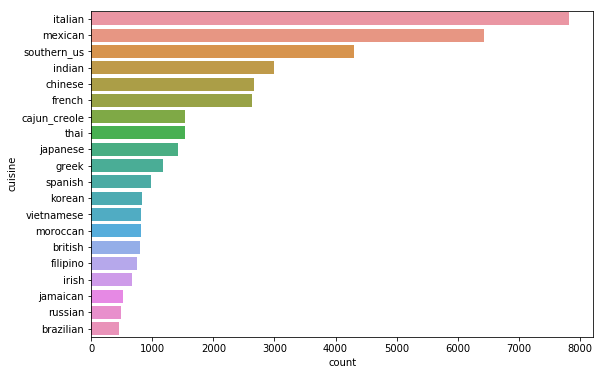

In [65]:
# plota a quantidade de ingredientes por tipo de cozinha
sns.countplot(y='cuisine', data=train, order = train['cuisine'].value_counts().index)
plt.show()

Por meio das informações e do gráfico acima, é possível notar que a cozinha com mais receitas presentes no conjunto de dados é a italiana, enquanto que a cozinha com menos receitas é a brasileira, que representam, respectivamente, 19.7% e 1.17% do conjunto de dados. 

Somente as três cozinhas com mais receitas (italiana, mexicana e sulista) já contemplam quase metade de todas as receitas do conjunto de treinamento (46.75%).

### Quantidade de ingredientes

Por conta dos tratamentos realizados nos dados, é interessante verificar se a quantidade de ingredientes mudou muito para as receitas:

In [41]:
train[train['processed_ingredients_qtt']<train['ingredients_qtt']]

,cuisine,id,ingredients,ingredients_qtt,processed_ingredients,ingredients_text,processed_ingredients_qtt
7176,mexican,27957,"[lime, simple syrup, 7 Up, lemon, grenadine, w...",11,"[lime, simple syrup, lemon, grenadine, wine, l...","lime, simple syrup, lemon, grenadine, wine, li...",10
10838,jamaican,10137,"[pepper, butter, coconut milk, any, curry, oli...",11,"[pepper, butter, coconut milk, curry, olive oi...","pepper, butter, coconut milk, curry, olive oil...",10
24870,southern_us,23724,"[granulated sugar, vanilla extract, 7 Up, vege...",8,"[granulated sugar, vanilla extract, vegetable ...","granulated sugar, vanilla extract, vegetable s...",7
27530,jamaican,17418,"[lime juice, jalapeno chilies, purple onion, p...",11,"[lime juice, jalapeno chilies, purple onion, p...","lime juice, jalapeno chilies, purple onion, po...",10
30770,filipino,42723,"[ketchup, Sriracha, sauce, garlic cloves, brow...",18,"[ketchup, sriracha, sauce, garlic clove, brown...","ketchup, sriracha, sauce, garlic clove, brown ...",17
31151,mexican,25985,"[avocado, jack, salsa, iceberg lettuce, canola...",13,"[avocado, jack, salsa, iceberg lettuce, canola...","avocado, jack, salsa, iceberg lettuce, canola,...",12
32313,filipino,8672,"[white vinegar, 7 Up, pork country-style ribs,...",9,"[white vinegar, pork country style rib, soy sa...","white vinegar, pork country style rib, soy sau...",8
37119,brazilian,21991,"[butter, sweetened condensed milk, other, choc...",4,"[butter, sweetened condensed milk, chocolate s...","butter, sweetened condensed milk, chocolate sp...",3


Como é possível notar acima, somente 8 receitas tiver uma redução no seu número de ingredientes, visto que possuíam listados como seus ingredientes os termos `7 Up`, `any` e `other`, que deixaram de existir quando foram removidas as *stopwords* e os caracteres númericos.

In [42]:
# visão geral das distribuições da quantidade de ingredientes presentes nas receitas
train['processed_ingredients_qtt'].describe()

count    39774.000000
mean        10.767511
std          4.429007
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: processed_ingredients_qtt, dtype: float64

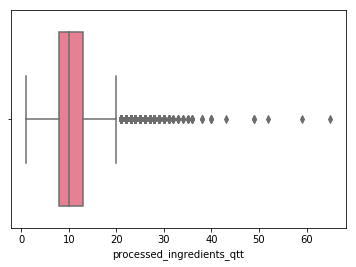

In [282]:
# plota o boxplot geral da quantidade de ingredientes
sns.boxplot(train['processed_ingredients_qtt'], palette=sns.color_palette("husl"))
plt.show()

A mediana das receitas presentes no conjunto de treinamento é de  10 ingredientes. E, segundo o boxplot acima, receitas com mais de 20 ingredientes são consideradas _outliers_.

O número mínimo de ingredientes que uma receita presente no conjunto de treinamento contém é 1, enquanto o número máximo é 65. Seguem as receitas contendo o número mínimo de ingredientes:

In [44]:
# lista as receitas com apenas 1 ingrediente
train[train['processed_ingredients_qtt'] == 1]

,cuisine,id,ingredients,ingredients_qtt,processed_ingredients,ingredients_text,processed_ingredients_qtt
940,japanese,4734,[sushi rice],1,[sushi rice],sushi rice,1
2088,vietnamese,7833,[dried rice noodles],1,[dried rice noodle],dried rice noodle,1
6787,indian,36818,[plain low-fat yogurt],1,[plain low fat yogurt],plain low fat yogurt,1
7011,indian,19772,[unsalted butter],1,[unsalted butter],unsalted butter,1
8181,japanese,16116,[udon],1,[udon],udon,1
8852,thai,29738,[sticky rice],1,[sticky rice],sticky rice,1
8990,indian,41124,[butter],1,[butter],butter,1
10506,mexican,32631,[corn tortillas],1,[corn tortilla],corn tortilla,1
13178,thai,29570,[grained],1,[grained],grained,1
17804,southern_us,29849,[lemonade concentrate],1,[lemonade concentrate],lemonade concentrate,1


Ao todo, são 22 receitas existentes no conjunto de dados contendo somente 1 ingrediente. Observando essa lista de ingredientes, parece mais que eles podem ser usados em conjunto com outros ingredientes do que sendo usados sozinhos para criar um prato. Por exemplo, a receita da cozinha japonesa de id _12805_ tem como ingrediente apenas água e é difícil imaginar um prato criado somente com ela; já a outra receita japonesa de id _16116_ que tem como único ingrediente o udon, que é um tipo de macarrão japonês, mas só tem essa massa como ingrediente e não constam os demais ingredientes, como molho de soja e dashi, para preparação do caldo que é servido junto com o macarrão. Por esse motivo, todos esses 22 exemplos serão excluídos na etapa de pré-processamento.

Além disso, essa lista permitiu verificar que há receitas repetidas no conjunto de dados: as receitas da cozinha indiana de ids _19772_, _14335_, e _27192_ contém o mesmo único ingrediente (_unsalted butter_, ou manteiga sem sal, em português). Portanto, será necessário remover esses exemplos duplicados na etapa de pré-processamento dos dados antes de treinar o modelo (uma análise mais detalhada desses casos será realizado mais abaixo).

Já com relação ao nṹmero máximo de ingredientes, temos o seguinte caso:

In [45]:
# lista as receitas com 65 ingredientes
train[train['processed_ingredients_qtt'] == 65]

,cuisine,id,ingredients,ingredients_qtt,processed_ingredients,ingredients_text,processed_ingredients_qtt
15289,italian,3885,"[fettucine, fresh marjoram, minced garlic, oli...",65,"[fettucine, fresh marjoram, minced garlic, oli...","fettucine, fresh marjoram, minced garlic, oliv...",65


In [46]:
train[train['processed_ingredients_qtt'] == 65]['processed_ingredients'].values

array([list(['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large egg', 'alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaf', 'salt', 'cayenne pepper', 'scallion', 'red bell pepper', 'boneless skinless chicken breast half', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomato', 'garlic', 'rice vinegar', 'neufchatel', 'garlic clove', 'dried parsley', 'frozen artichoke heart', 'penne', 'pepper', 'sweet onion', 'part skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaf', 'onion powder', 'red wine vinegar', 'red pepper flake', 'orzo', 'crushed red pepper', 'purpose flour', 'freshly ground pepper', 'sliced mushroom', 'panko breadcrumb', 'plum tomato', 'fresh basil', 'fresh leav spinach', 'water', 'sun dried tomato', 'ground pepper', 'grated parmesan cheese', 'boneless skinless chicken breast', 'chicken cut

A receita acima, cuja classe é de cozinha italiana, parece ser um dado escrito erroneamente. Isso porque contém diversos tipos de massa (fettucine, spaghetti, penne, orzo e até mesmo soba, que é um tipo de massa de origem japonesa, não italiana), de molhos, queijos (incluindo até um queijo francês, o Neufchâtel) e pimentas. Alguns ingredientes parecem ser os mesmos, mas escritos de maneiras diferentes (por exemplo, _freshly ground pepper_ e _ground pepper_). Com essa diversidade e quantidade enorme de ingredientes, pode-se tratar de diversas receitas que, por algum erro, acabaram agrupadas em uma única receita. 

Além desse caso extremo de 65 ingredientes, o boxplot acima indica que há outliers no conjunto de dados. Por meio dele, é possível observar que receitas a partir de 20 ingredientes são considerados outliers; entretanto, essas receitas estão mais próximas umas das outras e podem indicar receitas mais complexas que requerem mais ingredientes para serem preparadas. Por esse motivo, serão verificados somente os casos de receitas com mais de 40 ingredientes, visto que, a partir dessa quantidade de ingredientes, as receitas começam a ficar mais espaçadas no boxplot:

In [47]:
# lista as receitas com mais de 40 ingredientes
train[train['processed_ingredients_qtt'] > 40][['cuisine','processed_ingredients','processed_ingredients_qtt']].values

array([['mexican',
        list(['condensed cream chicken soup', 'pepper', 'refried bean', 'boneless skinless chicken breast', 'onion powder', 'condensed cream mushroom soup', 'garlic', 'shredded parmesan cheese', 'non stick spray', 'shredded cheese', 'lemon juice', 'onion', 'soy sauce', 'crushed tomato', 'lasagna noodle', 'swiss cheese', 'deli ham', 'dry sherry', 'salt', 'salsa', 'italian seasoned breadcrumb', 'turkey sausage link', 'ground beef', 'italian seasoning', 'tomato', 'black bean', 'milk', 'flour tortilla', 'chili powder', 'butter', 'diced tomato', 'boneless skinless chicken', 'rice', 'taco seasoning', 'enchilada sauce', 'fresh parsley', 'chicken', 'tomato sauce', 'water', 'garlic powder', 'french fried onion', 'ricotta cheese', 'fresh green bean', 'chicken stock cube', 'broccoli', 'tortilla chip', 'shredded mozzarella cheese', 'ground turkey', 'cabbage']),
        49],
       ['italian',
        list(['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powd

Vendo as 6 receitas acima que possuem mais de 40 ingredientes, podemos notar que há algo estranho nelas. É possível observar que há receitas que misturam ingredientes doces com salgados (divisão esta apenas para simplificar). Seguem alguns exemplos com alguns dos ingredientes listados:

|Cozinha| Ingredientes "doces"| Ingredientes "salgados"|
|-------|-------------------|----------------------|
|indiana|nutella, açúcar de coco e açúcar|polenta, mostarda inglesa, berinjela e macarrão para chow mein|
|mexicana|sorvete de baunilha, mel, cookies de chocolate e mistura para brownie|cebola roxa, feijão preto, aspargos, peito de frango e tortilha de milho|
|brasileira|marshmallows, leite condensado, extrato de baunilha, abacate, banana e mel| queijo cheddar, mostarda dijon, peito de frango e dashi |
|italiana|extrato de baunilha e açúcar|chouriço, massa para conchiglione, pão e batata |

Todas essas receitas contém uma extensa lista de ingredientes que, combinados, não parecem compor uma receita que possa, de fato, existir. Por exemplo, a primeira receita mexicana, apesar de só levar ingredientes "salgados" apresenta uma combinação de ingredientes que dificilmente correspondem a uma receita real (dentre seus ingredientes estão massa para lasanha, tortilhas, arroz, molho de soja e feijão preto). Já observando o caso brasileiro, é muito difícil imaginar que exista uma receita combinando marshmallows, queijo cheddar, mel, queijo suiço, cookies de chocolate, peito de frango e mais 53 ingredientes para formar um prato brasileiro, indicando que este exemplo é um erro existente no conjunto de dados.

Portanto, essas 6 receitas (incluindo o caso extremo da receita italiana de 65 ingredientes, que é a receita com o maior número de ingredientes presentes no conjunto de dados) serão consideradas outliers e removidas do conjunto de treinamento.

### Quantidade de ingredientes por cozinha

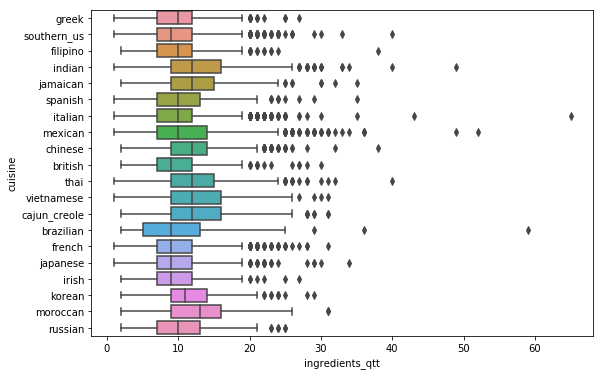

In [67]:
sns.boxplot(x = "ingredients_qtt", y = "cuisine", data = train, palette=sns.color_palette("husl"))
plt.show()

Por meio do plot acima, é possível notar que algumas receitas tem seus quartis deslocados mais para cima e outros mais para baixo, indicando que a maioria das receitas para aquele tipo de cozinha possuem mais ou menos ingredientes, respectivamente.

A mediana da cozinha marroquina é a maior do conjunto de treinamento, indicando que muitas das suas receitas são mais longas do que as demais cozinhas.

Por outro lado, as medianas das cozinhas irlandesa, japonesa, francesa, brasileira, britânica e sulista indicam que muitas das suas receitas são mais curtas do que as demais presentes no conjunto de dados.

Há também cozinhas cuja mediana coincide com a mediana geral do conjunto de dados, que são a russa, mexicana, italiana, espanhola, filipina e grega.

### Quantidade de receitas duplicadas

In [49]:
# agrupando os exemplos por tipo de cozinha e lista de ingredientes para encontrar os casos de duplicações
train[train.duplicated(subset=['cuisine','ingredients_text'], keep=False)].sort_values(['ingredients_text', 'cuisine'])

,cuisine,id,ingredients,ingredients_qtt,processed_ingredients,ingredients_text,processed_ingredients_qtt
21169,southern_us,39729,"[bacon drippings, butter, large eggs, salt, ba...",8,"[bacon dripping, butter, large egg, salt, baki...","bacon dripping, butter, large egg, salt, bakin...",8
34646,southern_us,1708,"[bacon drippings, butter, large eggs, salt, ba...",8,"[bacon dripping, butter, large egg, salt, baki...","bacon dripping, butter, large egg, salt, bakin...",8
21211,southern_us,14563,"[bacon drippings, buttermilk, large eggs, whit...",7,"[bacon dripping, buttermilk, large egg, white ...","bacon dripping, buttermilk, large egg, white c...",7
26167,southern_us,41900,"[bacon drippings, buttermilk, large eggs, whit...",7,"[bacon dripping, buttermilk, large egg, white ...","bacon dripping, buttermilk, large egg, white c...",7
28999,jamaican,15092,"[black pepper, cooking spray, ground allspice,...",12,"[black pepper, cooking spray, ground allspice,...","black pepper, cooking spray, ground allspice, ...",12
32464,jamaican,23405,"[black pepper, cooking spray, ground allspice,...",12,"[black pepper, cooking spray, ground allspice,...","black pepper, cooking spray, ground allspice, ...",12
3920,moroccan,24841,"[butter, carrots, white onion, cumin seed, pla...",9,"[butter, carrot, white onion, cumin seed, plai...","butter, carrot, white onion, cumin seed, plain...",9
30600,moroccan,28529,"[butter, carrots, white onion, cumin seed, pla...",9,"[butter, carrot, white onion, cumin seed, plai...","butter, carrot, white onion, cumin seed, plain...",9
2311,southern_us,20316,"[butter, powdered sugar, cream cheese, soften,...",4,"[butter, powdered sugar, cream cheese soften, ...","butter, powdered sugar, cream cheese soften, v...",4
18016,southern_us,20794,"[butter, powdered sugar, cream cheese, soften,...",4,"[butter, powdered sugar, cream cheese soften, ...","butter, powdered sugar, cream cheese soften, v...",4


No total, são 190 receitas que aparecem mais de uma vez no conjunto de dados. Para resolver isso, será mantido somente o primeiro exemplo de cada receita a aparecer no conjunto de treinamento:

In [50]:
train.drop_duplicates(subset=['cuisine','ingredients_text'], keep='first', inplace=True)

In [51]:
train.shape

(39677, 7)

Como é possível notar acima, foram removidas 97 receitas duplicadas que existiam no conjunto de dados original.

### Quantidade de ingredientes duplicados

In [52]:
# função para contabilizar a quantidade de ingredientes únicos
def unique(data):
    return list(dict.fromkeys(data))

train['unique_ingredients_qtt'] = train['processed_ingredients'].apply(lambda x: len(unique(x)))

In [53]:
train[train['unique_ingredients_qtt']<train['processed_ingredients_qtt']]

,cuisine,id,ingredients,ingredients_qtt,processed_ingredients,ingredients_text,processed_ingredients_qtt,unique_ingredients_qtt
334,mexican,1667,"[Old El Paso™ mild red enchilada sauce, Pillsb...",8,"[old el paso mild red enchilada sauce, pillsbu...","old el paso mild red enchilada sauce, pillsbur...",8,6
6494,greek,26165,"[olive oil, salt, dried oregano, ground black ...",18,"[olive oil, salt, dried oregano, ground black ...","olive oil, salt, dried oregano, ground black p...",18,9
7269,brazilian,5099,"[dried black beans, linguica, vegetable oil, s...",29,"[dried black bean, linguica, vegetable oil, sa...","dried black bean, linguica, vegetable oil, sal...",29,28
7591,mexican,32183,"[avocado, red enchilada sauce, Old El Paso™ ch...",14,"[avocado, red enchilada sauce, old el paso cho...","avocado, red enchilada sauce, old el paso chop...",14,9
7940,italian,33666,"[fresh basil, parmigiano reggiano cheese, fine...",12,"[fresh basil, parmigiano reggiano cheese, fine...","fresh basil, parmigiano reggiano cheese, fine ...",12,11
12328,italian,11839,"[cremini mushrooms, olive oil, dry red wine, w...",14,"[cremini mushroom, olive oil, dry red wine, wh...","cremini mushroom, olive oil, dry red wine, who...",14,13
14695,italian,46318,"[fresh basil, parmigiano reggiano cheese, grou...",15,"[fresh basil, parmigiano reggiano cheese, grou...","fresh basil, parmigiano reggiano cheese, groun...",15,14
18333,cajun_creole,44864,"[celery ribs, milk, extra-virgin olive oil, sc...",20,"[celery rib, milk, extra virgin olive oil, sca...","celery rib, milk, extra virgin olive oil, scal...",20,19
25358,cajun_creole,18780,"[chicken schmaltz, ground black pepper, bay le...",24,"[chicken schmaltz, ground black pepper, bay le...","chicken schmaltz, ground black pepper, bay lea...",24,23
27887,italian,34410,[Pillsbury™ Refrigerated Crescent Dinner Rolls...,16,"[pillsbury refrigerated crescent dinner roll, ...","pillsbury refrigerated crescent dinner roll, s...",16,10


O conjunto de treinamento possui 19 receitas com ingredientes que aparecem mais de uma vez em sua lista de ingredientes.
A receita com mais ingredientes duplicados é a grega de id *26165*, na qual todos os 9 ingredientes únicos(`olive oil`, `salt`, `dried oregano`, `ground black pepper`, `fresh oregano`, `beef stock`, `garlic clove`, `baking potato` e `lemon juice`) aparecem duas vezes, indicando que a lista de ingredientes está duplicada.

Os ingredientes duplicados serão removidos da lista, de modo que cada ingrediente apareça somente uma vez:

In [54]:
# remoção dos ingredientes duplicados
train['processed_ingredients'] = train['processed_ingredients'].apply(lambda x: list(set(x)))

In [55]:
# conta a quantidade de ingredientes novamente para verificar se os ingredientes duplicados foram removidos
train['processed_ingredients_qtt'] = train['processed_ingredients'].apply(lambda x: len(x))

# verifica novamente se a quantidade de ingredientes na lista é maior do que a quantidade de ingredientes únicos
train[train['unique_ingredients_qtt']<train['processed_ingredients_qtt']]

,cuisine,id,ingredients,ingredients_qtt,processed_ingredients,ingredients_text,processed_ingredients_qtt,unique_ingredients_qtt


A lista acima não retornou nenhuma receita, indicando que agora nenhuma receita possui ingredientes duplicados.

### Ingredientes mais e menos utilizados nas receitas

Pela nuvem de palavras abaixo, podemos notar que os ingredientes mais utilizados pelas receitas presentes no conjunto de dados são temperos como sal e pimenta e também para a preparação dos alimentos como óleo, cebola e alho.

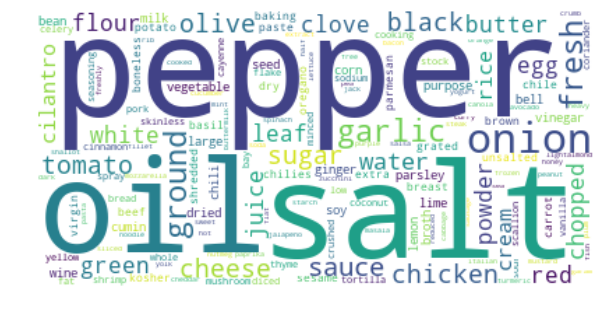

In [68]:
# gera a nuvem de palavras com os ingredientes mais frequentes em todas as receitas do conjunto de dados
text = " ".join(str(review) for review in train.ingredients_text)
wordcloud = WordCloud(background_color="white", collocations=False).generate(text)
plt.figure(num=None,  dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [57]:
# conta as vezes que cada ingrediente foi utilizado ao longo de todo conjunto de treinamento
count = Counter([i for sublist in train.processed_ingredients for i in sublist])

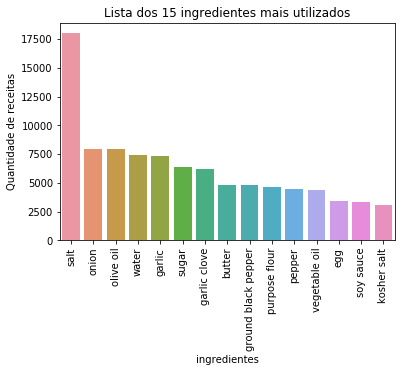

In [287]:
most_common = pd.DataFrame(count.most_common(15))
sns.barplot(most_common[0], most_common[1])
plt.title('Lista dos 15 ingredientes mais utilizados')
plt.xticks(rotation=90)
plt.xlabel('ingredientes')
plt.ylabel('Quantidade de receitas')
plt.show()

O ingrediente mais utilizado é o sal, que está presente na lista de ingredientes de cerca de 45% das receitas do conjunto de dados. O segundo ingrediente mais comum é a cebola, mas ela não é tão utilizado quanto o sal, visto que está presente em apenas cerca de 20% das receitas. 

Ao contrário do que ocorreu na nuvem de palavras, a pimenta não foi um ingrediente tão utilizado. Isso porque na nuvem de palavras, foi contabilizado cada palavra individualmente, enquanto que no gráfico acima são contabilizados cada ingrediente. Portanto, isso indica que há diversos tipos de pimenta descritos no conjunto de dados (como a pimenta-do-reino e pimenta-caiena, além de pimentões que estão descritos no conjunto de dados como `bell pepper`) e que muitas delas não estão descritas de maneira genérica somente como `pepper`. 

Por aparecer em tantas receitas, é possível que o sal não tenha um poder de predição tão alto, visto que não deve ser característico de um determinado tipo de cozinha. O mesmo deve ocorrer para os outros ingredientes muito frequentes em diversos tipos de cozinha.

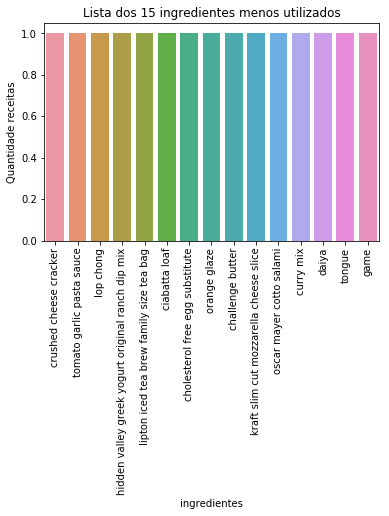

In [286]:
least_common = pd.DataFrame(count.most_common()[:-16:-1])
sns.barplot(least_common[0], least_common[1])
plt.title('Lista dos 15 ingredientes menos utilizados')
plt.xticks(rotation=90)
plt.xlabel('ingredientes')
plt.ylabel('Quantidade receitas')
plt.show()

In [60]:
# conta a quantidade de ingredientes que aparecem somente em uma receita
count_least_common = 0
for i in count.values():
    if i == 1:
        count_least_common += 1
print(count_least_common)        

1747


Há 1747 ingredientes que só aparecem em uma única receita. Algumas hipóteses para que isso ocorra são:
* Ingredientes muito descritivos e/ou com o nome da marca (por exemplo, `hidden valley greek yogurt original ranch dip mix`)
* Ingredientes que geralmente são incomuns e pouco utilizados (por exemplo, `tongue`)
* Erros no conjunto de dados, como itens que não são ingredientes que possam ser utilizados para preparar um prato (por exemplo, `game`)

Assim como os ingredientes muito frequentes, esses ingredientes pouco utilizados não devem ter um alto poder de predição, visto que aparecem somente em uma receita.

### Ingredientes mais utilizados por tipo de cozinha

In [61]:
# cria um dicionário para armazenar os ingredientes utilizados em cada cozinha
ingredients_by_cuisine = {}
for i, row in train.iterrows():
    for k in row.processed_ingredients:
        if row.cuisine in ingredients_by_cuisine:
            ingredients_by_cuisine[row.cuisine].append(k)
        else:
            ingredients_by_cuisine[row.cuisine] = [k]

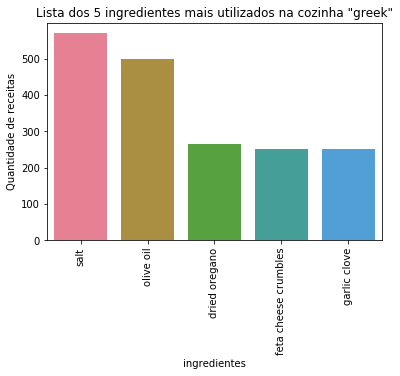

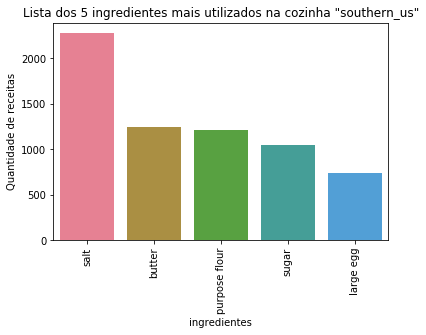

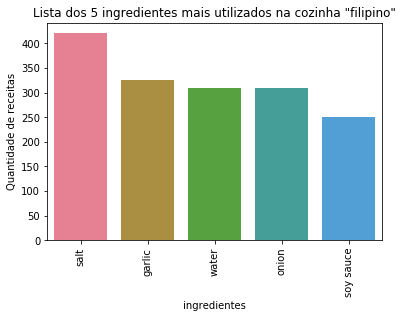

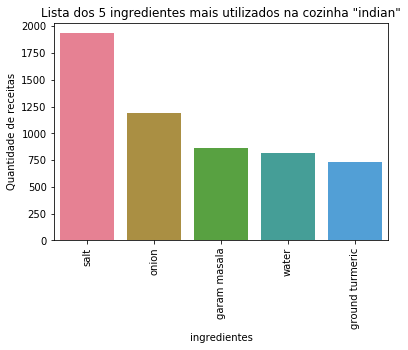

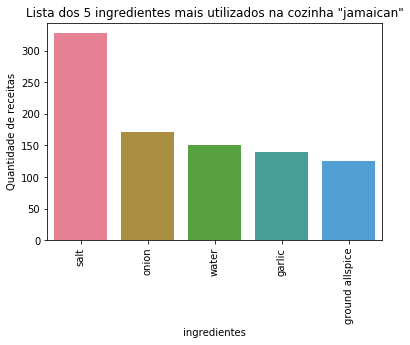

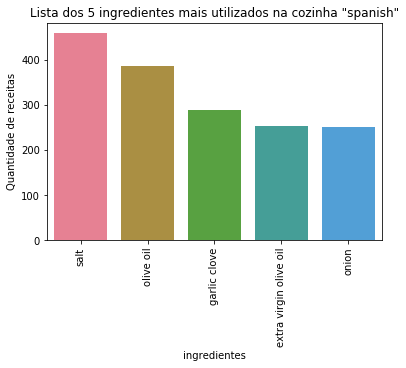

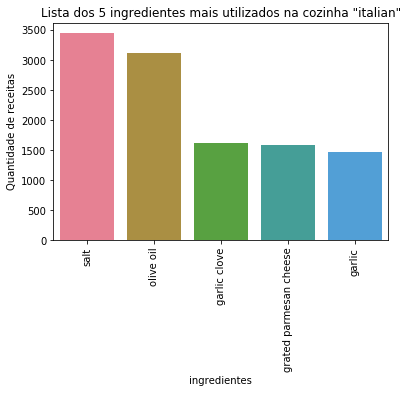

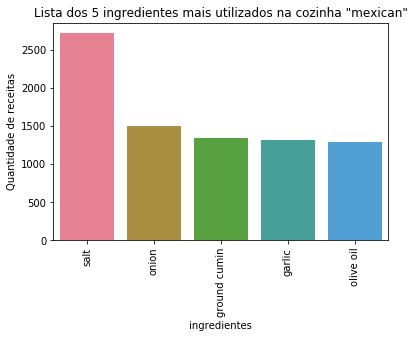

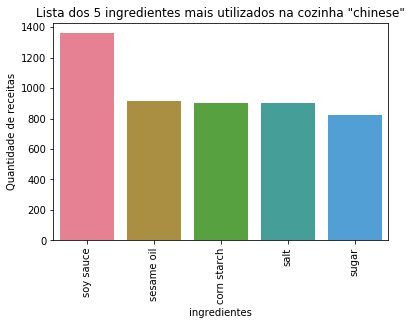

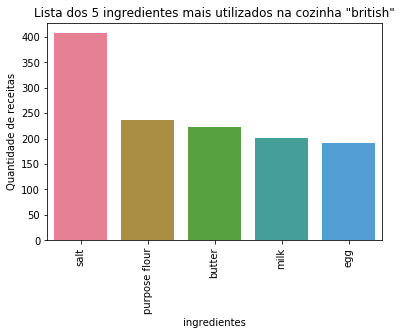

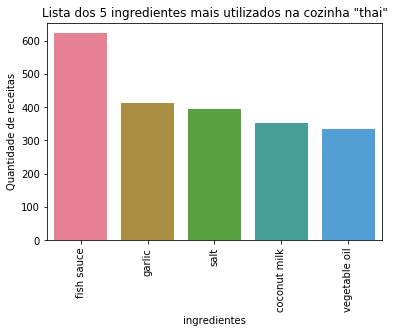

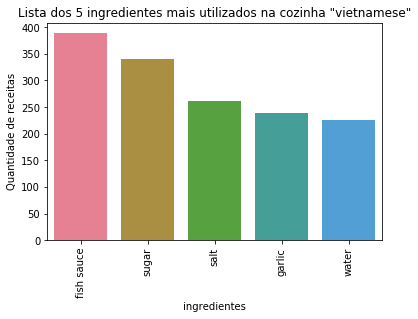

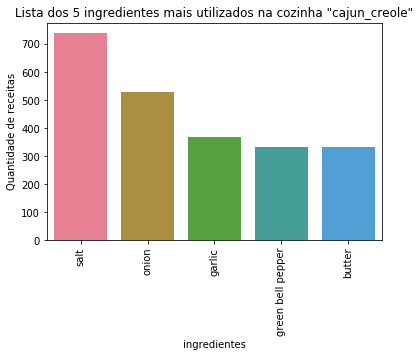

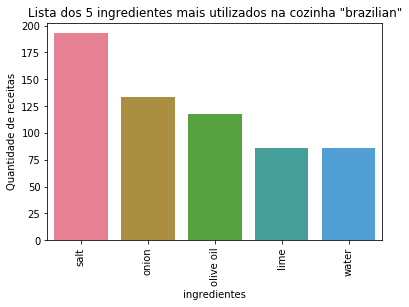

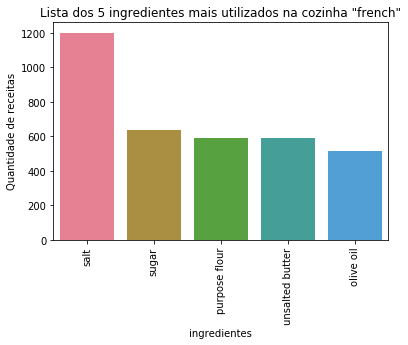

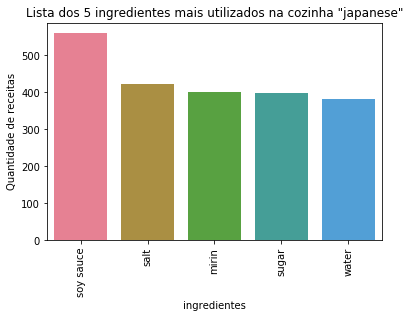

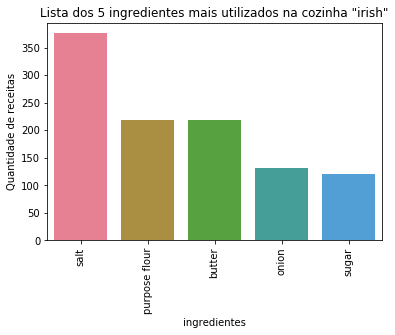

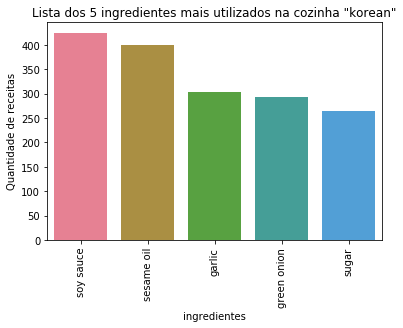

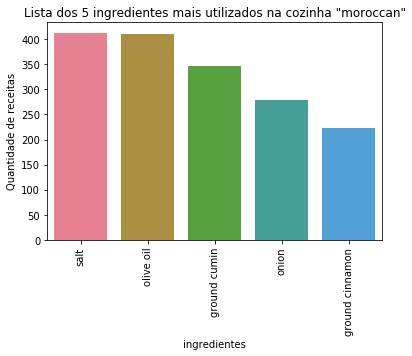

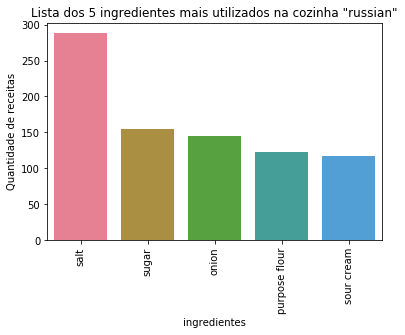

In [285]:
# gera um gráfico com os 5 ingredientes mais utilizados em cada tipo de cozinha
for x in ingredients_by_cuisine:
    count_by_cuisine = Counter([i for i in ingredients_by_cuisine[x]])
    most_common = pd.DataFrame(count_by_cuisine.most_common(5))
    sns.barplot(most_common[0], most_common[1], palette=sns.color_palette("husl"))
    plt.title(f'Lista dos 5 ingredientes mais utilizados na cozinha "{x}"')
    plt.xticks(rotation=90)
    plt.xlabel('ingredientes')
    plt.ylabel('Quantidade de receitas')
    plt.show()

Esses gráficos dos ingredientes mais utilizados por tipo de cozinha permite notar que, de modo geral, as cozinhas asiáticas, diferente das demais, possuem outros ingredientes mais utilizados ao invés do sal, como o molho de soja (nas cozinhas japonesa, chinesa e coreana) e o molho de peixe (nas cozinhas vietnamita e tailandesa). 

Também é possível notar que as cozinhas marroquina, grega, espanhola e italiana utilizam bastante azeite de oliva, visto que a quantidade utilizada nas receitas é similar ou muito próxima da de sal.

### Ingredientes únicos por tipo de cozinha

In [86]:
# gera a lista de ingredientes únicos presentes somente em cada cozinha
unique_ingredients = []

for cuisine in train['cuisine'].unique():
    current_cuisine = set(train[train['cuisine'] == cuisine]['processed_ingredients'].sum())
    other_cuisine = set(train[train['cuisine'] != cuisine]['processed_ingredients'].sum())
    unique_ingredients.append({
        'cuisine': cuisine,
        'ingredients': current_cuisine - other_cuisine
    })

,cuisine,ingredients
0,greek,"{pita wedge, grape vine leaf, manouri, greek s..."
1,southern_us,"{back rib, collard, buttermilk ranch dressing,..."
2,filipino,"{lumpia wrapper, ox tongue, small potato, holl..."
3,indian,"{kashmiri chile, white bread slice, tamari alm..."
4,jamaican,"{pickapeppa sauce, passover wine, cherry syrup..."
5,spanish,"{cava, garden cress, citrus vinaigrette, burri..."
6,italian,"{chicken nugget, cappuccino, vanilla vodka, st..."
7,mexican,"{budweiser, fat free cheddar cheese, mexican b..."
8,chinese,"{knorr homestyl stock beef, kikkoman oyster sa..."
9,british,"{sweet white wine, rum raisin ice cream, beef ..."


In [88]:
unique_ingredients_in_cuisine = pd.DataFrame(unique_ingredients, columns=['cuisine', 'ingredients'])

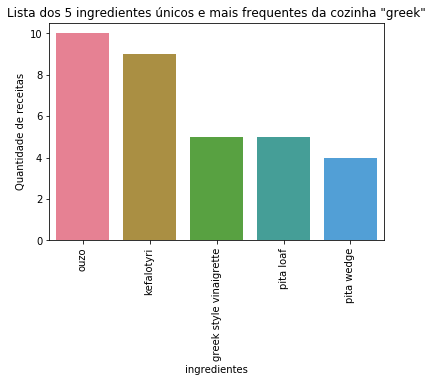

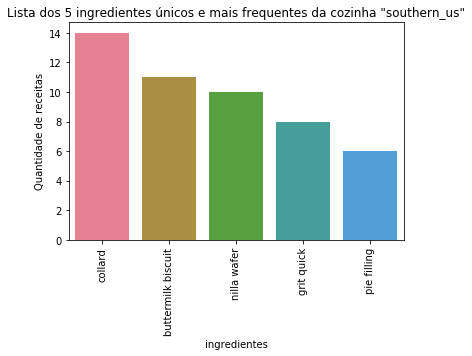

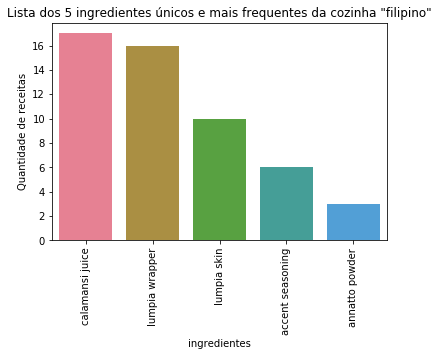

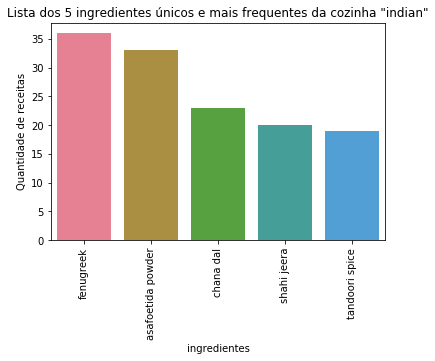

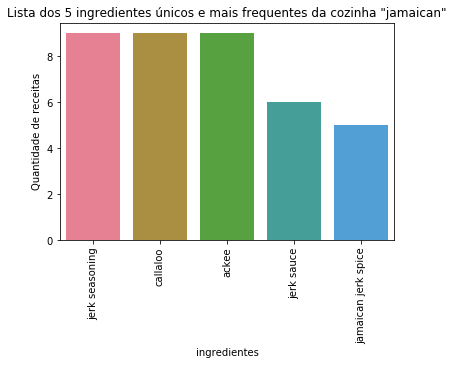

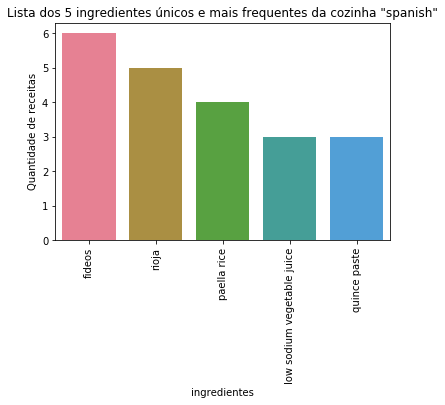

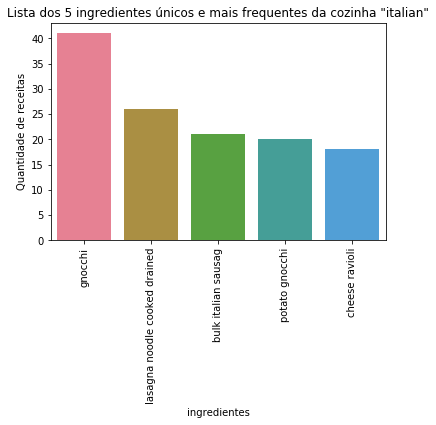

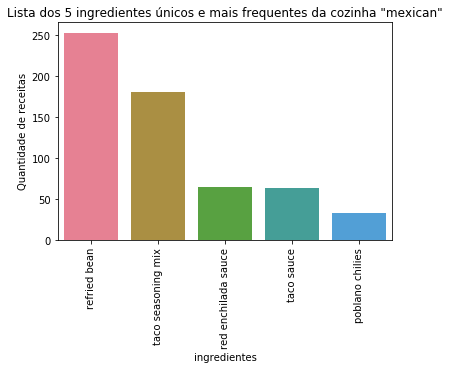

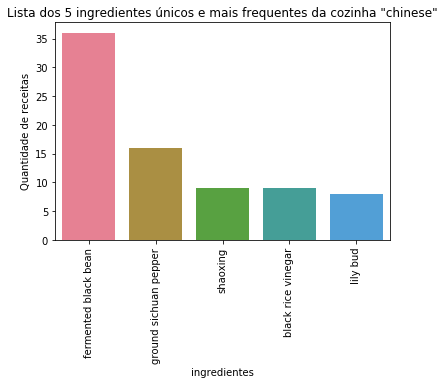

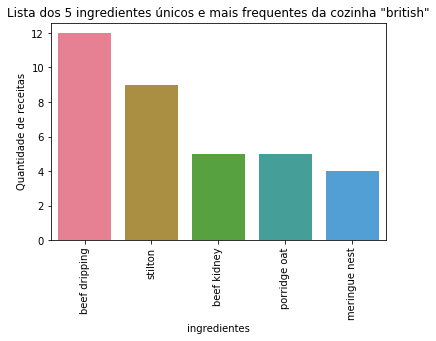

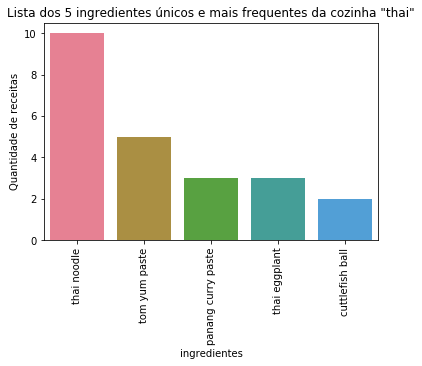

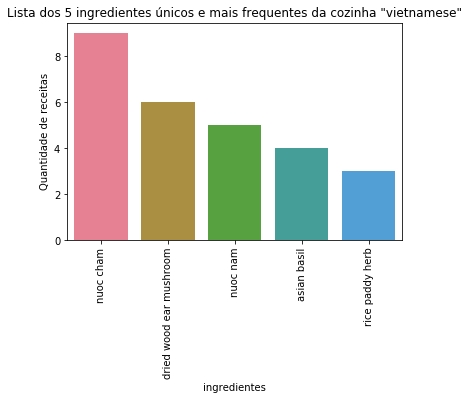

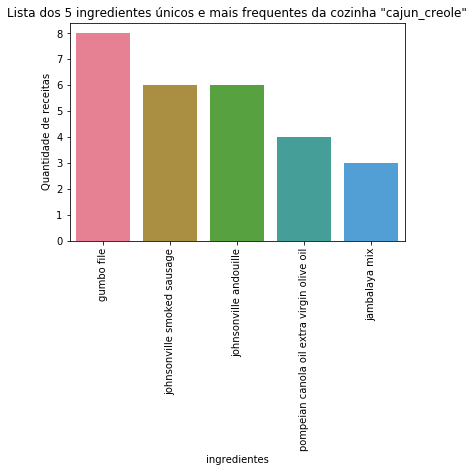

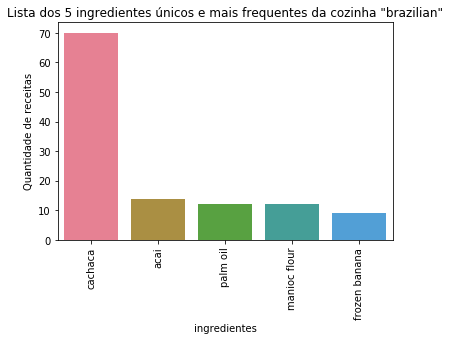

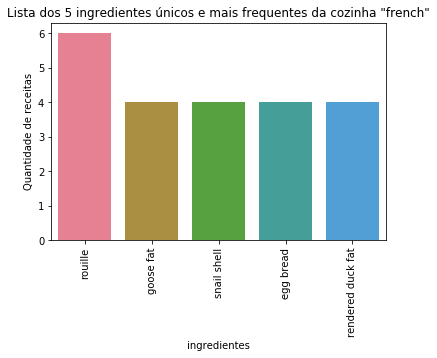

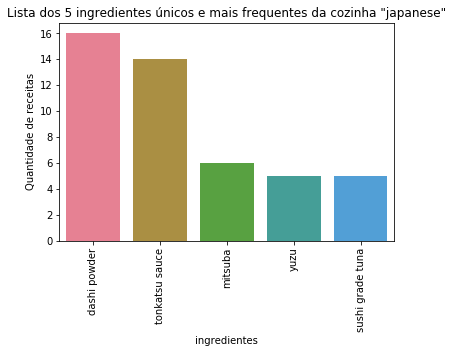

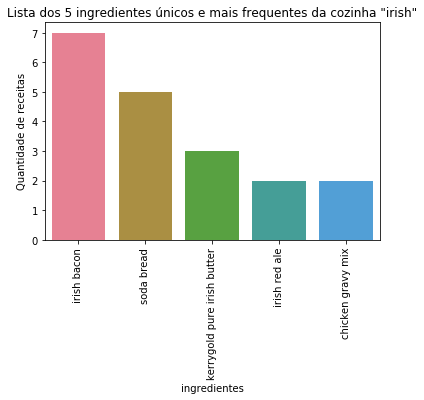

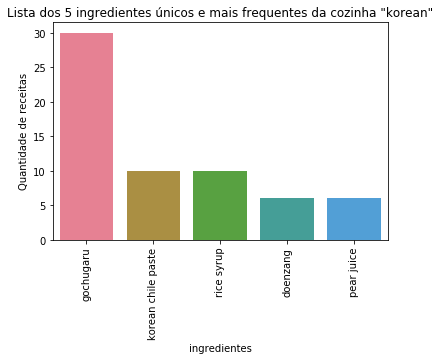

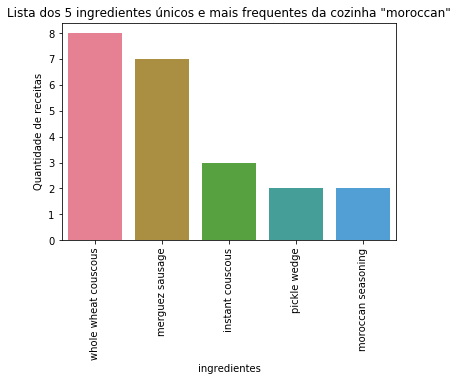

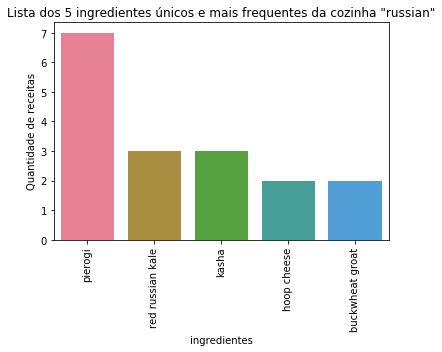

In [288]:
# itera sobre a lista de ingredientes únicos por cozinha e o dataset original para contar a frequência de uso dos ingredientes
for i in unique_ingredients_in_cuisine.cuisine:
    count_unique_ingredients_per_cuisine = {}
    counter = Counter([k for sublist in train[train.cuisine==i].processed_ingredients for k in sublist])
    unique_ingredients_per_cuisine = unique_ingredients_in_cuisine[unique_ingredients_in_cuisine.cuisine==i]['ingredients']
    for j in unique_ingredients_per_cuisine.index:
        list_of_ingredients = unique_ingredients_per_cuisine[unique_ingredients_per_cuisine.index==j]
        for ingredient in list_of_ingredients[j]:
            for k in counter:
                if k == ingredient:
                    if ingredient in count_unique_ingredients_per_cuisine:
                        count_unique_ingredients_per_cuisine[ingredient].append(counter[k])
                    else:
                        count_unique_ingredients_per_cuisine[ingredient] = counter[k]
    count_unique_ingredients_per_cuisine = sorted(count_unique_ingredients_per_cuisine.items(), key=itemgetter(1), reverse=True)[:5]
    x_val = [x[0] for x in count_unique_ingredients_per_cuisine]
    y_val = [x[1] for x in count_unique_ingredients_per_cuisine]
    sns.barplot(x_val, y_val, palette=sns.color_palette("husl"))
    plt.title(f'Lista dos 5 ingredientes únicos e mais frequentes da cozinha "{i}"')
    plt.xticks(rotation=90)
    plt.xlabel('ingredientes')
    plt.ylabel('Quantidade de receitas')
    plt.show()

Pelos gráficos acima, é possível notar que algumas cozinhas não tem ingredientes tão característicos que são únicos para elas. Observando em números absolutos, os ingredientes únicos das cozinhas russa, jamaicana, irlandesa, marroquina, vietnamita, espanhola, cajun/creoula e francesa que mais frequentes só aparecem em menos de 10 de suas receitas, indicando que, pelo menos para as receitas presentes no conjunto de dados, essas cozinhas não tem tantos ingredientes característicos e que são específicos de suas cozinhas.

A tabela abaixo resume essa visão, apresentando a cozinha, o seu ingrediente único mais frequente, em quantas receitas diferentes ele aparece e a proporção de receitas da respectiva cozinha que ele aparece:

|#|cozinha|ingrediente mais utilizado| frequência| % das receitas|
|--|--|---|--|--|
|1|brasileira|cachaça|70|15.11%|
|2|britânica|beef dripping|12|1.49%|
|3|cajun/crioula|gumbo file|8|0.52%|
|4|chinesa|fermented black bean|36|1.35%|
|5|filipina|calamansi juice|17|2.25%|
|6|francesa|rouille|6|0.22%|
|7|grega|ouzo|10|0.85%|
|8|indiana|fenugreek|36|1.20%|
|9|irlandesa|irish bacon|7|1.04%|
|10|italiana|gnocchi|41|0.52%|
|11|jamaicana|jerk seasoning|9|1.72%|
|12|japonesa|dashi powder|16|1.13%|
|13|coreana|gochugaru|30|3.62%|
|14|mexicana|refried bean|253|3.93%|
|15|marroquina|whole wheat couscous|8|0.97%|
|16|russa|pierogi|7|1.43%|
|17|sulista (do sul dos Estados Unidos)|collard|14|0.32%|
|18|espanhola|fideos|6|0.60%|
|19|tailandesa|thai noodle|10|0.65%|
|20|vietnamita|nuoc cham|9|1.09%|

A cozinha brasileira é a que parece ter o ingrediente mais representativo, visto que a cachaça, ingrediente único mais frequente, aparece em cerca de 15% das receitas brasileiras. Isso indica que há muitas receitas brasileiras no conjunto de dados para preparação de bebidas, visto que não há tantos pratos brasileiros que utilizam cachaça em sua preparação. Seguem algumas dessas receitas que são de bebidas que usam cachaça:
* lime, crushed ice, simple syrup, cachaca
* cachaca, pineapple juice, lemon lime beverage
* crushed ice, cachaca, lime, superfine sugar
* water, strawberry, lemon, granulated sugar, lime, cachaca
* fresh lime, passion fruit juice, granulated sugar, cachaca
* simple syrup, liqueur, lime, ice, cachaca
* sugar, cachaca, ice, lime
* lime, cachaca, lime slice, sugar, ice
* cachaca, cold water, ice, lime, simple syrup
* sugar, cachaca, lime
* sugar, cachaca, lime, ice cube
* cachaca, sugar, ice, lime
* kiwi fruit, sugar, lime, cachaca
* lime, cachaca, kiwi fruit, sugar

Essa lista também permite notar que há diversas receitas para a caipirinha, só trocando a ordem dos ingredientes (há uma receita com a ordem `açúcar, chacaça, gelo e limão` e outra com `chacaça, açúcar, gelo e limão`) ou adicionando alguns ingredientes a mais (algumas acrescentam cubos de gelo ou frutas como o kiwi).

Em números absolutos, o ingrediente único que mais parece é o `refried bean` da cozinha mexicana, que aparece em 253 receitas. Entretanto, ele só aparece em menos de 4% das receitas mexicanas, visto que a quantidade de receitas mexicanas presentes no conjunto de dados é alta.

Portanto, esses ingredientes mais representativos podem ter um bom poder de predição para essas cozinhas por serem exclusivos dessas cozinhas.

## Conclusões da análise exploratória

* Não será necessário realizar um tratamento com relação aos valores faltantes porque não há casos assim no conjunto de treinamento.
* As colunas `id` e `ingredients` não serão utilizadas para a criação do modelo. O `id` não será utilizado porque é apenas uma coluna identificadora e única para cada receita e, portanto, não possui poder de classificação e que permita distinguir os exemplos. Já a feature `ingredients` está em um formato um pouco mais díficil de se trabalhar por se tratar de uma lista de strings; em seu lugar, será utilizada a feature `ingredients_text`, que contém todos os ingredientes presentes na lista mas em uma única string, o que facilita o processo de modelagem.
* Também será acrescentada a feature `ingredients_qtt` para armazenar a quantidade de ingredientes utilizada em cada receita para fornecê-la ao modelo essa informação e ver o seu poder para auxiliar na predição das classes.
* Durante a fase de pré-processamento, será necessário realizar uma limpeza e tratamento do conjunto de dados, que serão as mesmas que foram acrescentadas durante esta análise exploratória:
    * Limpeza dos dados
        * Exclusão das receitas repetidas 
        * Exclusão de ingredientes repetidos na lista de ingredientes de algumas receitas
        * Exclusão de outliers (receitas com apenas 1 ingrediente ou com mais de 40)
    * Tratamento dos dados
        * Conversão de todas as palavras para letras minúsculas
        * Remoção de caracteres númericos e especiais
        * Remoção de palavras indicando unidades de medida
        * Remoção de stopwords
        * Lematização das palavras